In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

# from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
# from sklearn.feature_selection import RFE, SelectKBest, chi2, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB

In [6]:
X = pd.read_csv("data/ml_projekt/X.csv")
odds = pd.read_csv("data/ml_projekt/all_odds.csv")

In this report we will use already built databe X, which constist of followings:
* First three columns consists information about the game (home team, away team and season)
* Next, there are statistics about the home team in general
* These statistics, as well as any other are divided into two groups: total cumulated over the entire season, as well as gathered only from the last 5 games
* Then there are statistics about players from every position: goalkeepers, defenders, midfielders and attackers (These are average statistics of every player playing in that position)
* The same pattern is repeated for away team
* Finally, there is target column (H - home win, X - draw, A - away win)

In [7]:
X

,ht,at,season,home_Team_total_games_played_home,home_Team_total_games_played_away,home_Team_total_goal_scored,home_Team_total_goal_scored_home,home_Team_total_goal_scored_away,home_Team_total_goal_conceded,home_Team_total_goal_conceded_home,...,away_Attacker_last_5_sub_shots_on_target,away_Attacker_last_5_sub_days_without_injury,away_Attacker_last_5_sub_has_played,away_Attacker_last_5_sub_wins,away_Attacker_last_5_sub_draws,away_Attacker_last_5_sub_lost,away_Attacker_sub_n_players,home_Attacker_prev_league_position,away_Attacker_prev_league_position,result
0,SC Freiburg,VfB Stuttgart,2012,0.40000,0.60000,1.800000,0.800000,1.000000,3.200000,0.400000,...,0.625000,75367.647059,0.800000,0.444444,0.333333,0.222222,2.0,19,19,A
1,Nice,AC Ajaccio,2012,0.60000,0.40000,0.375000,0.375000,0.000000,1.200000,0.800000,...,0.000000,18145.161290,0.800000,0.333333,0.444444,0.222222,1.0,21,21,H
2,Valenciennes,Dijon FCO,2012,0.40000,0.60000,0.600000,0.200000,0.400000,1.600000,0.400000,...,0.200669,49975.094286,0.733333,0.469697,0.265152,0.265152,3.0,21,21,H
3,Nurnberg,Werder Bremen,2012,0.40000,0.60000,1.000000,0.400000,0.600000,1.000000,0.400000,...,0.996442,23557.495392,0.700000,0.714286,0.142857,0.142857,2.0,19,19,X
4,Lille,Sochaux,2012,0.40000,0.60000,1.800000,0.600000,1.200000,1.200000,0.600000,...,0.310345,32528.735632,0.400000,0.587302,0.642857,0.103175,3.0,21,21,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7967,Genoa,Crotone,2017,0.50000,0.50000,1.100000,0.750000,0.350000,1.350000,0.450000,...,0.000000,103458.498024,0.600000,0.392308,0.303846,0.303846,2.0,10,21,X
7968,Chelsea,Hull,2017,0.47619,0.52381,2.142857,1.333333,0.809524,0.714286,0.285714,...,0.000000,197907.647908,0.466667,0.621212,0.204545,0.174242,3.0,10,21,H
7969,AS Monaco,Lorient,2017,0.50000,0.50000,3.000000,1.700000,1.300000,1.050000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3,15,H
7970,Real Betis,Sporting Gijon,2017,0.50000,0.50000,1.111111,0.666667,0.444444,1.666667,0.666667,...,1.200000,26516.129032,0.600000,0.442308,0.278846,0.278846,2.0,10,17,X


In [8]:
X_to_test = X.loc[:, X.columns[3:]]
X_full, y_full = X_to_test.loc[:, X_to_test.columns != "result"], X["result"]
scaler = MinMaxScaler().fit(X_full)
X_transformed = scaler.transform(X_full)

ss = StratifiedShuffleSplit(test_size=0.2, random_state=1)
train_idx, test_idx = next(ss.split(X_transformed, y_full))

X_train, X_test = X_transformed[train_idx, :], X_transformed[test_idx, :]

X_train_data = X.loc[train_idx, :].reset_index(drop=True)
X_train_data.loc[:, X.columns[3:-1]] = X_train

X_test_data = X.loc[test_idx, :].reset_index(drop=True)
X_test_data.loc[:, X.columns[3:-1]] = X_test

y_train, y_test = y_full.loc[train_idx], y_full.loc[test_idx]
y_train_data = y_train.reset_index(drop=True)

In [15]:
models = [KNeighborsClassifier(), AdaBoostClassifier(), RandomForestClassifier(), SVC(), DecisionTreeClassifier(), LogisticRegression(max_iter=1000), GaussianNB(), ExtraTreesClassifier()]
names = ["KNeighborsClassifier", "AdaBoostClassifier", "RandomForestClassifier", "SVC", "DecisionTreeClassifier", "LogisticRegression", "GaussianNB", "ExtraTreesClassifier"]
for model, name in zip(models, names):
    print(f"scores for {name}:")
    scores = cross_val_score(model, X_train, y_train, scoring="accuracy")
    print(scores)
    print(f"mean: {np.mean(scores):.5f}")
    print(f"std:  {np.std(scores):.5f}")
    print()

#best results: SVC, GaussianProcess, RandomForest

scores for KNeighborsClassifier:
[0.43495298 0.45454545 0.44470588 0.42980392 0.42117647]
mean: 0.43704
std:  0.01161

scores for AdaBoostClassifier:
[0.50470219 0.5        0.46745098 0.49960784 0.47843137]
mean: 0.49004
std:  0.01450

scores for RandomForestClassifier:
[0.53605016 0.51489028 0.50039216 0.5254902  0.50588235]
mean: 0.51654
std:  0.01294

scores for SVC:
[0.53134796 0.52664577 0.50509804 0.51686275 0.51764706]
mean: 0.51952
std:  0.00905

scores for DecisionTreeClassifier:
[0.41222571 0.40360502 0.41803922 0.39058824 0.39529412]
mean: 0.40395
std:  0.01020

scores for LogisticRegression:
[0.49059561 0.48510972 0.48235294 0.47372549 0.47921569]
mean: 0.48220
std:  0.00565

scores for GaussianNB:
[0.37147335 0.4184953  0.37960784 0.35215686 0.35686275]
mean: 0.37572
std:  0.02355

scores for ExtraTreesClassifier:
[0.52115987 0.51959248 0.49647059 0.50666667 0.50431373]
mean: 0.50964
std:  0.00941



Both Random Forest Classifier and SVC show biggest promise.

To impove performance of SVC algorithm, we will apply dimensionality reduction via PCA

In [18]:
svc = Pipeline([
    ('dim_red', PCA(random_state=1)),
    ('svc', SVC(random_state=1))
])

param_grid = {
    'dim_red__n_components': [300, 320, 340, 360, 380],
    'svc__C': [0.003, 0.01, 0.03],
    'svc__kernel': ['linear', 'rbf', 'sigmoid']
}

svc_search = GridSearchCV(svc, param_grid, cv=3, scoring='accuracy')
svc_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('dim_red', PCA(random_state=1)),
                                       ('svc', SVC(random_state=1))]),
             param_grid={'dim_red__n_components': [300, 320, 340, 360, 380],
                         'svc__C': [0.003, 0.01, 0.03],
                         'svc__kernel': ['linear', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [25]:
print(svc_search.best_params_)
print('cross val score:', svc_search.best_score_)
print('test score:', accuracy_score(y_test, svc_search.best_estimator_.predict(X_test)))

{'dim_red__n_components': 380, 'svc__C': 0.01, 'svc__kernel': 'linear'}
cross val score: 0.5159150757198457
test score: 0.534796238244514


In [29]:
rfc = RandomForestClassifier(random_state=1)

param_grid = {
    'n_estimators': [510, 520, 530, 540, 550],
    'max_features': ['sqrt', 'log2', 10, 30, 50, 70],
    'min_samples_leaf': [20, 21, 22, 23]
}

rfc_search = GridSearchCV(rfc, param_grid, cv=3, scoring='accuracy')
rfc_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_features': ['sqrt', 'log2', 10, 30, 50, 70],
                         'min_samples_leaf': [20, 21, 22, 23],
                         'n_estimators': [510, 520, 530, 540, 550]},
             scoring='accuracy')

In [30]:
print(rfc_search.best_params_)
print('cross val score:', rfc_search.best_score_)
print('test score:', accuracy_score(y_test, rfc_search.best_estimator_.predict(X_test)))

{'max_features': 50, 'min_samples_leaf': 20, 'n_estimators': 520}
cross val score: 0.5198359802999281
test score: 0.5385579937304075


In [13]:
svc = Pipeline([
    ('dim_red', PCA(random_state=1, n_components=380)),
    ('svc', SVC(random_state=1, C=0.01, kernel="linear", probability=True))
])
svc.fit(X_train, y_train)

rfc = RandomForestClassifier(random_state=1, max_features=50, min_samples_leaf=20, n_estimators=520)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_features=50, min_samples_leaf=20, n_estimators=520,
                       random_state=1)

### Strategy

Now we will try to find strategy how to use prediction from our models to gain profit from bookies
For now we will try three simple strategies:
* SimpleStrategy - for every game, make prediction who will win, find the bookie who offers the best odds and make a bet
* BetterProbStrategy - as above, but only if probability is greater than 1/odds (the odds are in our favour)
* KellyCriterion - Using [Kelly Criterion](https://en.wikipedia.org/wiki/Kelly_criterion) to determine how much to put in a bet

In [9]:
def get_season(date):
    _, month, year = date.split("/")
    if int(month) > 6:
        return 2000 + int(year) + 1
    return 2000 + int(year)

class AbstractStrategy:
    def __format__(self, format_spec):
        frmat = "{" + f":<{format_spec}" + "}"
        return frmat.format(self.__str__())
    
    def strategy(self, pred, odds, curr_money, model, prob):
        raise NotImplementedError

    def get_bets(self, ht, at, season, odds):
        games_odds = odds.loc[(odds["HomeTeam"] == ht) & (odds["AwayTeam"] == at), :]
        for _, game in games_odds.iterrows():

            if get_season(game["Date"]) == season:

                # Found correct game
                bets = list(odds.columns[23:44]) + list(odds.columns[65:-3])
                res = {}
                for i, who in zip(range(3), ["H", "X", "A"]):
                    correct_bets = bets[i::3]
                    res[who] = max(game[correct_bets])
                    if res[who] != res[who]:
                        return None
                    res[who] = [res[who]]

                return res
        
        raise ValueError(ht, at, season)

    def calcScore(self, model, X, odds, initial_inv=1, tax=0):

        score, n, curr_money = 0, 0, initial_inv
        
        data = X.loc[:, X.columns[3:-1]].values

        preds = model.predict(data)

        try:
            probs = model.predict_proba(data)
        except AttributeError:
            probs = [None]*len(preds)

        for (_, row), pred, prob  in zip(X.iterrows(), preds, probs):
            ht, at, season, result = row["ht"], row["at"], row["season"], row["result"]

            game_odds = self.get_bets(ht, at, season, odds)
            if game_odds is not None:

                my_bets = self.strategy(pred, game_odds, curr_money, model, prob)

                for who, how_much, odd in my_bets:
                    n += 1
                    if who != result:
                        score -= how_much
                        curr_money -= how_much
                    else:
                        score += how_much*(odd - 1)*(1 - tax)
                        curr_money += how_much*(odd - 1)*(1 - tax)

        try:
            return score, score/n, n
        except ZeroDivisionError:
            return 0, 0, 0

In [10]:
class SimpleStrategy(AbstractStrategy):
    def strategy(self, pred, odds, curr_money, model, prob):
        return [(pred, 1, odd) for odd in odds[pred]]
    def __str__(self): 
        return "Simple Strategy:"

class BetterProbStrategy(AbstractStrategy):
    def __str__(self): 
        return "Better Prob Strategy:"
    
    def strategy(self, pred, odds, curr_money, model, prob):
        res = []
        for ind, who in enumerate(model.classes_):
            for odd in odds[who]:
                if prob[ind] > 1/odd:
                    res.append((who, 1, odd))
        return res
    
class KellyCriterion(AbstractStrategy):
    def __init__(self, scale=1):
        self.scale = scale
    def __str__(self): 
        return f"Kelly Criterion({self.scale}):"

    def strategy(self, pred, odds, curr_money, model, prob):
        res = []
        for ind, who in enumerate(model.classes_):
            for odd in odds[who]:
                frac = (prob[ind]*odd - 1)/(odd - 1)
                if frac > 0:
                    res.append((who, self.scale*frac*curr_money, odd))
        return res

In [91]:
strategies = [SimpleStrategy(), BetterProbStrategy(), KellyCriterion(), KellyCriterion(0.5), KellyCriterion(0.25)]
models = [rfc, svc]
m_names = ["rfc", "svc"]

for model, m_name in zip(models, m_names):
    print(f"{m_name}:")
    found_good = False
    
    fold = KFold(random_state=1, shuffle=True, n_splits=5)
    for strategy in strategies:

        full_profit, n_games = 0, 0
        for cv_train_idx, cv_test_idx in fold.split(X_train_data):
            X_cv_train = X_train_data.loc[cv_train_idx, X_train_data.columns[3:-1]]
            X_cv_test = X_train_data.loc[cv_test_idx, :]
            y_cv_train = y_train_data[cv_train_idx]

            model.fit(X_cv_train, y_cv_train)
            total, _, n = strategy.calcScore(model, X_cv_test, odds)
            full_profit += total
            n_games += n
        
        if full_profit > 0:
            print(f"{strategy} {full_profit:8.3f} {full_profit/n_games:.5f} ({n_games})")
            found_good = True
            
    if not found_good:
        print("No viable strategy")

rfc:
No viable strategy
svc:
Simple Strategy:   72.539 0.01138 (6376)


In [48]:
svc.fit(X_train, y_train)
strategy = SimpleStrategy()
total, ratio, n = strategy.calcScore(svc, X_test_data, odds)
print(total, ratio, n)

0.013289028213166148


SimpleStrategy with SVC does bring profit across both train and test set. 

Other strategy that is interesting to look at is ThresholdStrategy. With that we will look only at odds that are from a certain margin.

In [11]:
class ThresholdStrategy(AbstractStrategy):
    def __init__(self, min_threshold, max_threshold):
        self.min_threshold = min_threshold
        self.max_threshold = max_threshold
    def __str__(self):
        return f"Threshold Strategy({self.min_threshold:.3f} - {self.max_threshold:.3f}):"
    
    def strategy(self, pred, odds, curr_money, model, prob):
        return [(pred, 1, odd) for odd in odds[pred] if odd >= self.min_threshold and odd <= self.max_threshold]

In [56]:
for model, m_name in zip(models, m_names):
    print(f"{m_name}:")
    found_good = False
    
    fold = KFold(random_state=1, shuffle=True, n_splits=5)
    for min_t, diff in itertools.product(np.arange(1.5, 3.301, 0.1), [0.1, 0.2]):

        max_t = min_t + diff
        full_profit, n_games = 0, 0
        strategy = ThresholdStrategy(min_t, max_t)
        for cv_train_idx, cv_test_idx in fold.split(X_train_data):
            X_cv_train = X_train_data.loc[cv_train_idx, X_train_data.columns[3:-1]]
            X_cv_test = X_train_data.loc[cv_test_idx, :]
            y_cv_train = y_train_data[cv_train_idx]

            model.fit(X_cv_train, y_cv_train)
            total, _, n = strategy.calcScore(model, X_cv_test, odds)
            full_profit += total
            n_games += n

        if full_profit > 0:
            print(f"{strategy} {full_profit:8.3f} {full_profit/n_games:.5f} ({n_games})")
            found_good = True
            
    if not found_good:
        print("No viable strategy")


rfc:
Threshold Strategy(1.500 - 1.700):    5.486 0.00626 (877)
Threshold Strategy(1.600 - 1.700):   15.720 0.03303 (476)
Threshold Strategy(1.600 - 1.800):   33.115 0.03708 (893)
Threshold Strategy(1.700 - 1.800):   17.395 0.04171 (417)
Threshold Strategy(1.700 - 1.900):   14.781 0.01989 (743)
Threshold Strategy(1.900 - 2.100):    6.840 0.00722 (948)
Threshold Strategy(2.000 - 2.100):   40.050 0.08521 (470)
Threshold Strategy(2.000 - 2.200):   24.490 0.02674 (916)
Threshold Strategy(2.200 - 2.300):    9.820 0.02431 (404)
Threshold Strategy(2.200 - 2.400):    9.850 0.01366 (721)
Threshold Strategy(2.300 - 2.400):    0.030 0.00009 (317)
Threshold Strategy(2.300 - 2.500):    8.440 0.01292 (653)
Threshold Strategy(2.400 - 2.500):    8.410 0.02503 (336)
Threshold Strategy(2.400 - 2.600):   23.980 0.04466 (537)
Threshold Strategy(2.500 - 2.600):   15.570 0.07746 (201)
Threshold Strategy(2.500 - 2.700):   27.800 0.06406 (434)
Threshold Strategy(2.600 - 2.700):   12.230 0.05249 (233)
Threshold

We can identify three larger areas with higher accuracy:
* 1.6 - 1.8
* 2.2 - 2.7
* 3.0 - 3.2

We will now score the most promising strategies according to cross validation, and the test set

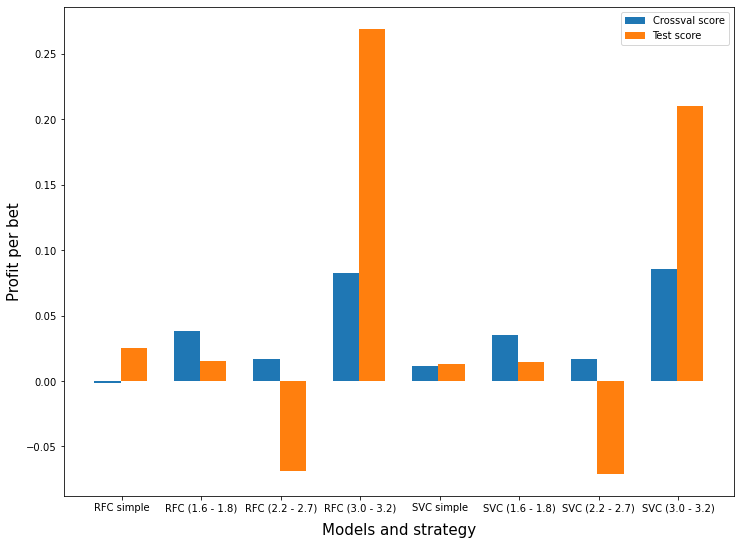

In [76]:
def get_strategy_score(model, strategy, TAX=0):
    
    fold = KFold(random_state=1, shuffle=True, n_splits=5)

    full_profit, n_games = 0, 0
    for cv_train_idx, cv_test_idx in fold.split(X_train_data):
        X_cv_train, X_cv_test = X_train_data.loc[cv_train_idx, X_train_data.columns[3:-1]], X_train_data.loc[cv_test_idx, :]
        y_cv_train = y_train_data[cv_train_idx]

        model.fit(X_cv_train, y_cv_train)
        total, _, n = strategy.calcScore(model, X_cv_test, odds, tax=TAX)
        full_profit += total
        n_games += n

    model.fit(X_train, y_train)
    _, ratio, _ = strategy.calcScore(model, X_test_data, odds, tax=TAX)
    return full_profit/n_games, ratio


models = [rfc, svc]
min_ts = [1.6, 2.2, 3.0]
max_ts = [1.8, 2.7, 3.2]

cross_val_scores = []
test_scores = []
names = []


for model, m_name in zip(models, ["RFC", "SVC"]):
    
    cv_score, test_score = get_strategy_score(model, SimpleStrategy())
    cross_val_scores.append(cv_score)
    test_scores.append(test_score)
    names.append(f"{m_name} simple")
    
    for min_t, max_t in zip(min_ts, max_ts):
        
        strategy = ThresholdStrategy(min_t, max_t)
        
        cv_score, test_score = get_strategy_score(model, strategy)
        cross_val_scores.append(cv_score)
        test_scores.append(test_score)
        names.append(f"{m_name} ({min_t} - {max_t})")
        
plt.rcParams['figure.figsize'] = (12, 9)
        
barwidth = 0.33
br1 = np.arange(len(names))
br2 = br1 + barwidth
plt.bar(br1, cross_val_scores, label="Crossval score", width=barwidth)
plt.bar(br2, test_scores, label="Test score", width=barwidth)
            
plt.xticks(barwidth + np.arange(len(names)) - 0.15, names, fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Models and strategy", fontsize=15, labelpad=10)
plt.ylabel("Profit per bet", fontsize=15)

plt.legend(fontsize=10)

## Bonus 1 - Feature importances

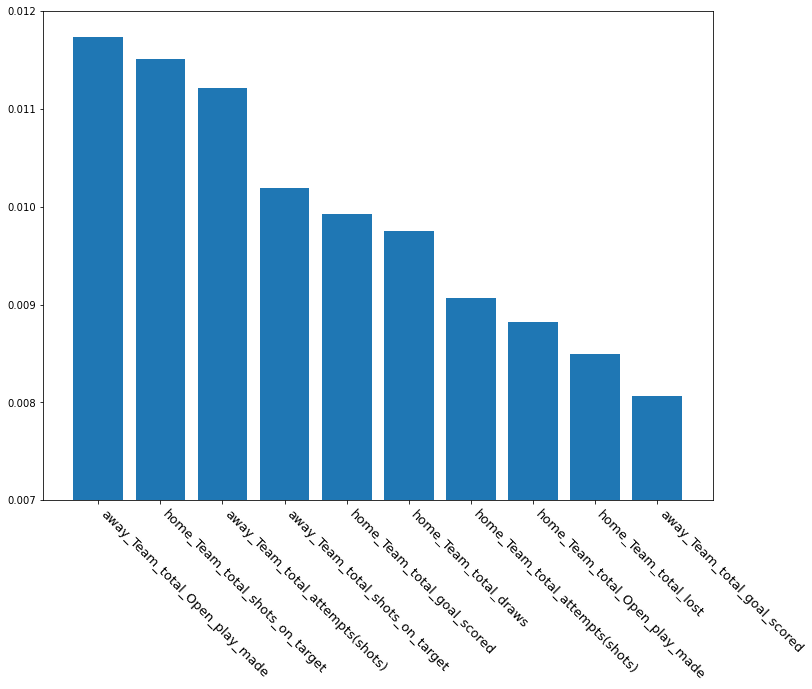

In [74]:
rfc.fit(X_train, y_train)

importances = rfc.feature_importances_
indices = np.argsort(rfc.feature_importances_)[-10:]
vals = importances[indices]
labels = X.columns[3:-1][indices]

plt.rcParams["figure.figsize"] = (12, 9)
plt.bar(range(vals.shape[0]), vals[::-1], align="center")
plt.xticks(range(vals.shape[0]), labels[::-1], rotation=-45.0, horizontalalignment='left', fontsize=13)
plt.ylim((0.007, 0.012))
plt.show()

In [75]:
for val, label in zip(vals[::-1], labels[::-1]):
    print(f"{label + ':':40} {val:.6f}")

away_Team_total_Open_play_made:          0.011736
home_Team_total_shots_on_target:         0.011515
away_Team_total_attempts(shots):         0.011216
away_Team_total_shots_on_target:         0.010195
home_Team_total_goal_scored:             0.009922
home_Team_total_draws:                   0.009749
home_Team_total_attempts(shots):         0.009070
home_Team_total_Open_play_made:          0.008824
home_Team_total_lost:                    0.008495
away_Team_total_goal_scored:             0.008062


## Bonus 2 - Tax
Until now we only considered simplified situation, without any tax, now we will try to find what happens if
we add taxation to our strategies.

In Poland, tax rate for placed bets is 12%, that means for example if you pay 1 zł for a bet, the result for a potential win 
are calculated as if you payed 0.88 zł.

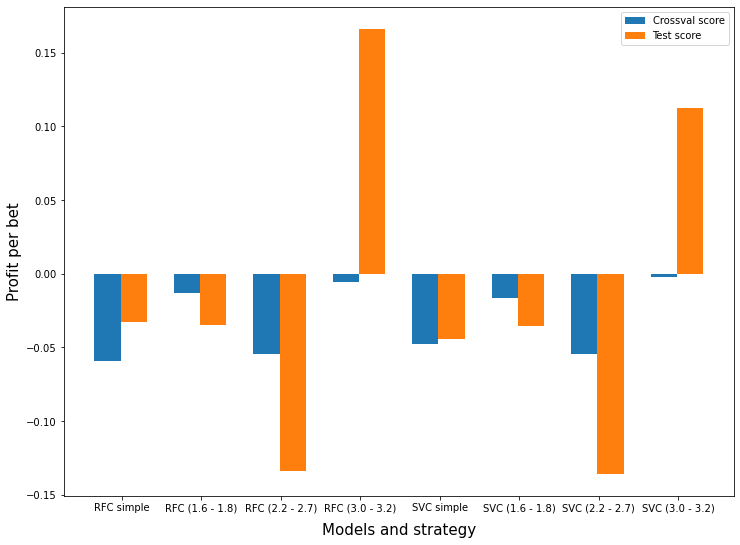

In [90]:
models = [rfc, svc]
min_ts = [1.6, 2.2, 3.0]
max_ts = [1.8, 2.7, 3.2]

cross_val_scores = []
test_scores = []
names = []


for model, m_name in zip(models, ["RFC", "SVC"]):
    
    cv_score, test_score = get_strategy_score(model, SimpleStrategy(), TAX=0.12)
    cross_val_scores.append(cv_score)
    test_scores.append(test_score)
    names.append(f"{m_name} simple")
    
    for min_t, max_t in zip(min_ts, max_ts):
        
        strategy = ThresholdStrategy(min_t, max_t)
        
        cv_score, test_score = get_strategy_score(model, strategy, TAX=0.12)
        cross_val_scores.append(cv_score)
        test_scores.append(test_score)
        names.append(f"{m_name} ({min_t} - {max_t})")
        
plt.rcParams['figure.figsize'] = (12, 9)
        
barwidth = 0.33
br1 = np.arange(len(names))
br2 = br1 + barwidth
plt.bar(br1, cross_val_scores, label="Crossval score", width=barwidth)
plt.bar(br2, test_scores, label="Test score", width=barwidth)
            
plt.xticks(barwidth + np.arange(len(names)) - 0.15, names, fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Models and strategy", fontsize=15, labelpad=10)
plt.ylabel("Profit per bet", fontsize=15)

plt.legend(fontsize=10)